In [2]:
%load_ext autoreload
%autoreload 1
    
%aimport qPCR

import qPCR as q
import pandas as pd, numpy as np
import seaborn as sns
import math

from qPCR import average_cq, sd_cq, sem_cq, tidy_df
from numpy import power, log
from scipy import stats
from scipy.stats.mstats import gmean

%matplotlib inline

In [152]:
path  = "../../Analyses/191122_qPCR/"
fname = "191122_WT58_GRIN"


# path_200117   = "../../Analyses/200117_qPCR/"
# fname_200117  = ["200117_WT58_gravel_non_gravel_pt1", "200117_WT58_gravel_non_gravel_pt2"]

# path_200129   = "../../Analyses/200129_qPCR/"
# fname_200129  = ["200129_WT58_gravel_non_gravel_pt1", "200129_WT58_gravel_non_gravel_pt2"]

file  = path+fname+'.csv'
df    = q.tidy_df(pd.read_csv(file, header=0),treatment=False)

# df_relde_negs = df_relexp.loc[(df_relexp['Target'] != 'BACTIN') & (df_relexp['Age'] != 'NEG')]
# df_zoom = df_exclude_negs.loc[(df_exclude_negs['Target'] != 'GRIN1A') & (df_exclude_negs['Target'] != 'GRIN1B')]

# sns.set(context='paper', style='whitegrid', palette="ch:2.5,-.2,dark=.3", font='sans-serif', font_scale=2, color_codes=True, rc=None)

# g = sns.catplot(x="Target", y="Rel Exp", hue='Age', data=df_exclude_negs, saturation=.5, kind="bar", ci=None, aspect=.6)
# (g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"],rotation=45).set_titles("{col_name}").despine(left=True))

# h = sns.catplot(x="Target", y="Rel Exp", hue='Age', data=df_zoom, saturation=.5, kind="bar", ci=None, aspect=.6)
# (h.set_axiexp       = rel_expression_ddcq(df, 'BACTIN')
# df_exclus_labels("", "Relative Expression").set_xticklabels(["2AA", "2AB", "2BA", "2BB"],rotation=45).set_titles("{col_name}").despine(left=True))

In [3]:
def amean_cq(seq):
    amean_cq = np.mean(seq)
    return amean_cq

def delta_delta_cq(control_avg, sample_avg):
    dcq = control_avg - sample_avg
    ddcq = power(2, dcq)
    return ddcq

log2 = lambda x: log(x)/log(2)

def stats_rq(RQ):

    log2_RQ = log2(RQ)
    sd_RQ   = np.std(log2_RQ, ddof=1)
    sem_RQ  = stats.sem(log2_RQ)
    
    bio_gmean_RQ  = gmean(RQ)
    log2_gmean_RQ = log2(bio_gmean_RQ)
    
    
    # 95% confidence interval [in this case a t statistic of 4.3 was used based on three samples per biological group (i.e., 2 degrees of freedom)]
    # of each group are then calculated from the log transformed normalized expression (columns 12–15
    
#     ci_low  = power(1+sd_RQ, log2_gmean_RQ )
#     ci_upp  =
    
    return sd_RQ, log2_gmean_RQ, sem_RQ


'''qPCR Calculations and Error Propagation
The data analysis and associated calculations for relative quantification involve multiple steps (Figure 5):
(i) extract the Cq values for each sample after inter-run calibration and calculate the mean Cq from the associated technical replicates;

(ii) determine the relative quantity by raisingone + the PCR efficiency (E) [determined from the standard curve (Figure 4C)] to the DCq [i.e., (1 + E)DCq];
(calculated by subtracting the mean Cq of all the samples within the control group from the mean Cq of the technical replicates
from each sample);

(iii) enumerate the normal- ized relative expression (equivalent to DDCq after log transformation) per sample by dividing
the relative quantity of a given target/sample (step 2) by the geometric mean of the relative quantities of two or more reference targets;

(iv) compute the average normalized expression of the samples in each biological group; and

(v) perform statistical analysis based on the log
transformed normalized expression per sample (Figure 5: column 9) [41].These calculations are complex because qPCR data are relative by nature
between samples or groups of samples, with normalization to reference genes, and calibration between plates. Additionally, qPCR measurements
are made on the log scale (Cq value) with statistical analysis performed in Cq space (i.e., DDCq values or using log-transformed relative
normal- ized expression), while expression levels are reported after linear transformation of the DDCq results.'''


untreated = [1.05, 0.92, 1.04]
treated   = [0.27, 0.74, 0.40]
u_sd, u_lgmean, u_sem = stats_rq(untreated)
t_sd, t_lgmean, t_sem = stats_rq(treated)

# ci_low  = power(1+u_sd, u_lgmean-(4.3)*u_sem)

ci_low  = power(1+0.11, 0-(4.3)*0.06)
ci_upp  = power(1+0.11, 0+(4.3)*0.06)




t = stats.ttest_ind(untreated, treated, equal_var = True)
ci_low, ci_upp

(0.9734343593185913, 1.0272906338543513)

In [188]:
def analyse_df(sample_df, ref_target, treatment=False):
    #---------------------------------------------------------------------------------------------------------
    """Description
    
    :param DataFrame sample_frame: A sample data frame.
    :param string ref_target: A string matching an entry of the Target column; reference gene;
        the target to use as the reference target (e.g. 'BACTIN')
    :return: A DataFrame with columns: Sample, Target, Age, DeltaCq, and Rel Exp.
    :rtype: DataFrame
    """
    
    relevant_cols = ['Sample', 'Cq', 'Condition']
    relevant_grps = ['Condition', 'Sample']
    if treatment: relevant_cols.append('Treatment'); relevant_grps.append('Treatment')
    
    # TODO treatment analysis?
    
    # select relevant columns from reference gene data and find mean of technical replicates
    ref_target_df             = sample_df.loc[sample_df['Target'] == ref_target, relevant_cols]
    ref_target_grouped_by_age = ref_target_df.groupby(relevant_grps)
    ref_target_mean_by_sample = ref_target_grouped_by_age.agg(amean_cq)
    
    ref_sample_grouped_by_age = sample_df.groupby(relevant_grps)
    
    # define conditions and initiate empty array and df
    unique_conditions = sample_df.Condition.unique()
    sample_dcq_series = []
    analysed_df       = pd.DataFrame({
                           'Sample': [],
                           'Target': [],
                           'Age': [],
                           'RQ': [],
                           'Treatment': []
                          })
    
    # iterate through unique 'conditions' i.e. ages and NEG, calculate relative quantity, and 
    for condition, group in ref_sample_grouped_by_age:
        for age in unique_conditions:
            if age == condition[0]:
                sample         = condition[1]
                
                ref_mean_cq    = ref_target_mean_by_sample.loc[[age, 'average_cq']]['Cq'][0]

#                 sample_mean_cq = amean_cq(group['Cq'])
#                 RQ      = delta_delta_cq(ref_mean_cq,sample_mean_cq)
#                 log2_RQ = log(RQ)
            
                sample_cq = group['Cq']
                RQs       = delta_delta_cq(ref_mean_cq,sample_cq) # 
                stats_RQ  = stats_rq(RQs)

                for RQ in RQs:
                    analysed_df = analysed_df.append({
                           'Sample'   : sample,
                           'Target'   : group['Target'].unique()[0],
                           'Age'      : age,
                           'RQ'       : RQ,
                           'Treatment': group['Treatment'].unique()[0]}
                             ,ignore_index=True)
    
                
    
#                 analysed_df = analysed_df.append({
#                            'Sample'   : sample,
#                            'Target'   : group['Target'].unique()[0],
#                            'Age'      : age,
#                            'RQ'       : RQ.tolist(),
#                            'Treatment': group['Treatment'].unique()[0]}
#                              ,ignore_index=True)


    return analysed_df
    

    


# analysed_df = analyse_df(df,'BACTIN')
# analysed_df

analysed_df = analyse_df(tidy_df(df_pt1, True), 'BACTIN', treatment=True)
analysed_df

# sns.set(context='paper', style='whitegrid', palette="ch:2.5,-.2,dark=.3", font='sans-serif', font_scale=2, color_codes=True, rc=None)

# g = sns.catplot(x="Target", y="RQ", hue='Age', data=analysed_df, saturation=.5, kind="bar", ci=None, aspect=.6)
# (g.set_axis_labels("", "Relative Expression").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB"],rotation=45).set_titles("{col_name}").despine(left=True))

# sns.swarmplot(x="Target", y="RQ", data=analysed_df)

,Sample,Target,Age,RQ,Treatment
0,3_1A,GRIN1A,3,0.032956,Gravel
1,3_1A,GRIN1A,3,0.034835,Gravel
2,3_1A,GRIN1A,3,0.044092,Gravel
3,3_1A,GRIN1A,3,0.004415,Non Gravel
4,3_1A,GRIN1A,3,0.015589,Non Gravel
5,3_1A,GRIN1A,3,0.028690,Non Gravel
6,3_1B,GRIN1B,3,0.023465,Gravel
7,3_1B,GRIN1B,3,0.056983,Gravel
8,3_1B,GRIN1B,3,0.100598,Gravel
9,3_1B,GRIN1B,3,0.018032,Non Gravel


In [215]:

def read_multi_csv(path, fname_arr):
    #---------------------------------------------------------------------------------------------------------
    # Reads multiple csv files. Input path of file and
    # array of filenames assuming they are in the same folder. Output a list of dataframes.
    
    df_list = []
    for i, df_name in enumerate(fname_arr):
        fname  = path+df_name+'.csv'
        df = pd.read_csv(fname, header=0)
        df['Plate'] = i+1
        df_list.append(df)
    return df_list

def concat_df(df_arr):
    #---------------------------------------------------------------------------------------------------------
    # Concatenates dataframes given as an list.
    concatenated = pd.concat(df_arr, sort=True)
    return concatenated

def plot_raw_cq(raw_df_arr, treatment):
    #---------------------------------------------------------------------------------------------------------
    # Plots raw cq values (not really useful) and returns a seaborn plot
    if len(raw_df_arr) > 1:
        df = concat_df(raw_df_arr)
    else: df = raw_df_arr[0]
    
    df = tidy_df(df, treatment)
    sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

    g = sns.catplot(x="Target", y="Cq", col="Condition", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df, saturation=.5, kind="bar", ci='sd', aspect=.6)
    (g.set_axis_labels("", "Cq").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))
    return g

def analyse_multi_df(path, fname_arr, ref_target, treatment):
    df_list     = read_multi_csv(path, fname_arr)
    tidy_df_list = []
    for df in df_list:
        t_df = tidy_df(df, treatment)
        tidy_df_list.append(t_df)
        
    analysed_df = analyse_df(concat_df(tidy_df_list), ref_target, treatment)
    return analysed_df

def plot_RQ():
    return 0

def strip_controls(df):
    
    stripped = df.loc[(df['Target'] != 'BACTIN') & (df['Age'] != 'NEG')]
    sort_d   = stripped.sort_values(['Target','Age','Treatment']).reset_index(drop=True)

#     df_zoom = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]
    return sort_d

def hide_1A_1B(df):
    df_zoom = df.loc[(df['Target'] != 'GRIN1A') & (df['Target'] != 'GRIN1B')]
    return df_zoom

# plot_raw_cq(read_multi_csv(path_200129, fname_200129), treatment = True)



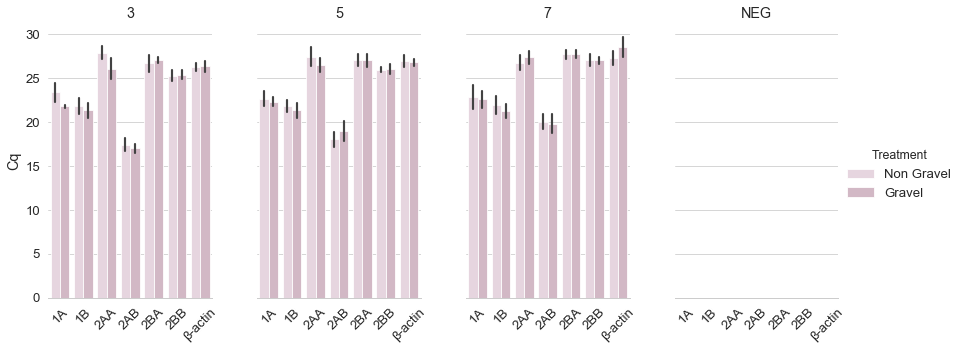

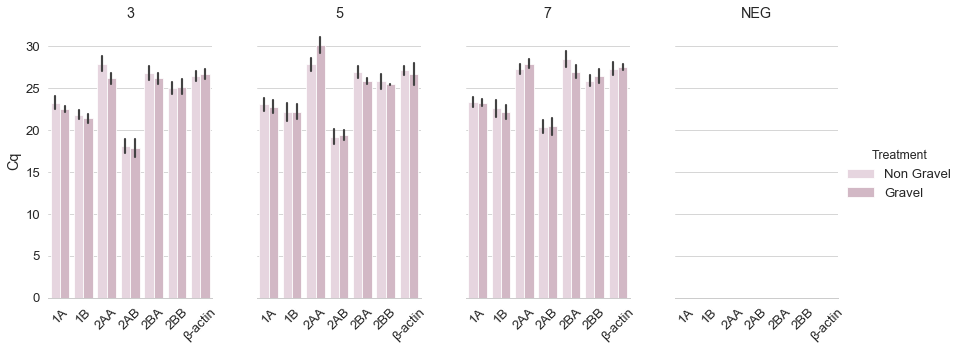

In [150]:

path_191122   = "../../Analyses/191122_qPCR/"
fname_191122  = "191122_WT58_GRIN"

path_200117   = "../../Analyses/200117_qPCR/"
fname_200117  = ["200117_WT58_gravel_non_gravel_pt1", "200117_WT58_gravel_non_gravel_pt2"]

path_200129   = "../../Analyses/200129_qPCR/"
fname_200129  = ["200129_WT58_gravel_non_gravel_pt1", "200129_WT58_gravel_non_gravel_pt2"]

raw_cq_200117 = plot_raw_cq(read_multi_csv(path_200117, fname_200117), treatment = True)
raw_cq_200129 = plot_raw_cq(read_multi_csv(path_200129, fname_200129), treatment = True)

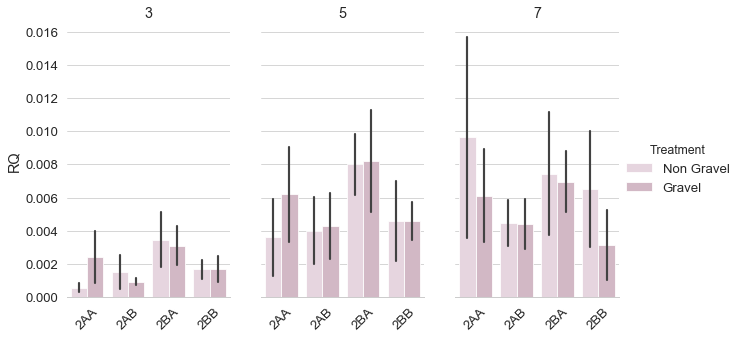

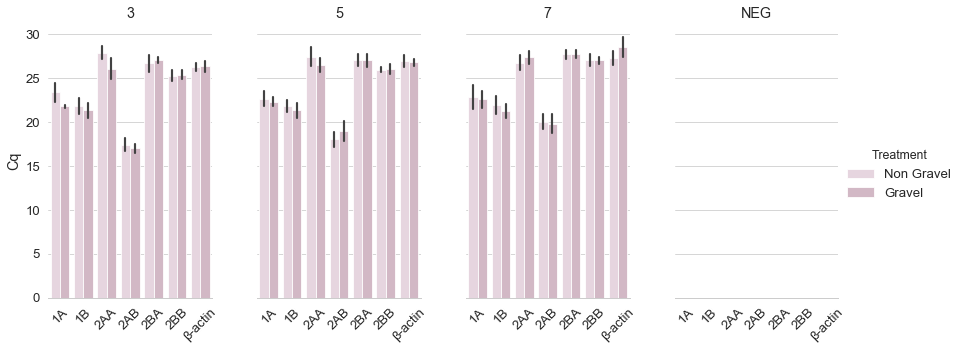

In [216]:
df_200117 = analyse_multi_df(path_200117, fname_200117, 'BACTIN', treatment=True)
df_200117 = strip_controls(df_200117)

sns.set(context='paper', style='whitegrid', palette="ch:7.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

# g = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df_200117, saturation=.5, kind="bar", ci='sd', aspect=.6)
# (g.set_axis_labels("", "RQ").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))

h = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=hide_1A_1B(df_200117), saturation=.5, kind="bar", ci='sd', aspect=.6)
(h.set_axis_labels("", "RQ").set_xticklabels(["2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))

raw_cq_200117 = plot_raw_cq(read_multi_csv(path_200117, fname_200117), treatment = True)



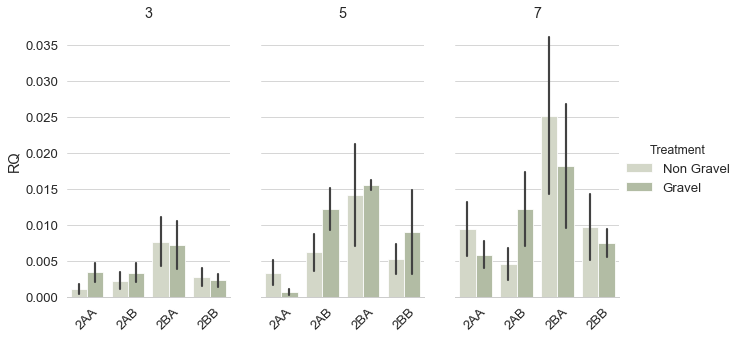

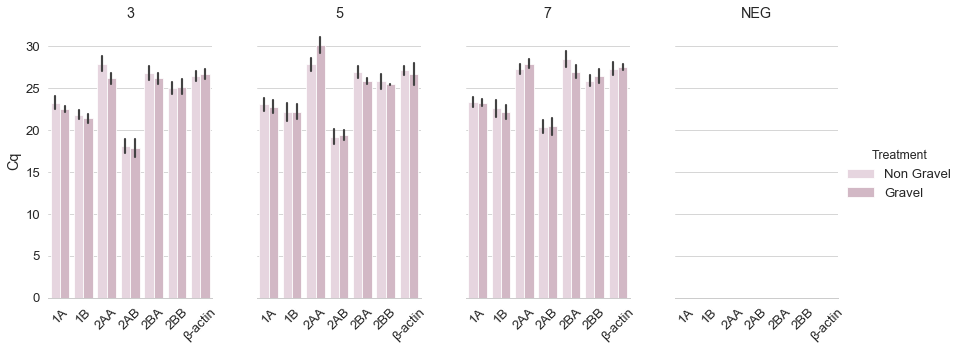

In [217]:
df_200129 = analyse_multi_df(path_200129, fname_200129, 'BACTIN', treatment=True)
df_200129 = strip_controls(df_200129)

sns.set(context='paper', style='whitegrid', palette="ch:8.1,-.2,dark=.3", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

# g = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=df_200129, saturation=.5, kind="bar", ci='sd', aspect=.6)
# (g.set_axis_labels("", "RQ").set_xticklabels(["1A", "1B", "2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))

h = sns.catplot(x="Target", y="RQ", col="Age", hue='Treatment', hue_order=['Non Gravel','Gravel'], data=hide_1A_1B(df_200129), saturation=.5, kind="bar", ci='sd', aspect=.6)
(h.set_axis_labels("", "RQ").set_xticklabels(["2AA", "2AB", "2BA", "2BB", "β-actin"], rotation=45).set_titles("{col_name}").despine(left=True))

raw_cq_200129 = plot_raw_cq(read_multi_csv(path_200129, fname_200129), treatment = True)

